In [1]:
%reset -f

In [2]:
# 79-character line limit
######### ######### ######### ######### ######### ######### ######### #########
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
# from scipy.optimize import linprog
from mip import Model, xsum, maximize, BINARY

Using Python-MIP package version 1.7.3


In [3]:
def correlations(intensities):
    x1h = intensities
    x2h = np.zeros([height, width])
    for i in range(0, height):
        for j in range(0, width-1):
            x2h[i][j] = x1h[i][j+1]
        x2h[i][width-1] = x1h[i][width-1]

    total_N = np.size(x1h)
    mean_x1h = x1h.sum()/total_N
    mean_x2h = x2h.sum()/total_N

    aa1 = (x1h - mean_x1h)**2
    bb1 = aa1.sum()
    std_dev1 = np.sqrt(bb1/total_N)

    aa2 = (x2h - mean_x2h)**2
    bb2 = aa2.sum()
    std_dev2 = np.sqrt(bb2/total_N)

    cc = (x1h - mean_x1h)*(x2h - mean_x2h)
    hcov = cc.sum()/total_N

    hcorr = hcov/(std_dev1 * std_dev2)
    print('hcorr', hcorr)

    # Vertical correlation
    x1v = intensities
    x2v = np.zeros([height, width])
    for i in range(0, height-1):
        for j in range(0, width):
            x2v[i][j] = x1v[i+1][j]
            x2v[height-1][j] = x1v[height-1][j]

    total_N = np.size(x1v)
    mean_x1v = x1v.sum()/total_N
    mean_x2v = x2v.sum()/total_N

    aa1 = (x1v - mean_x1v)**2
    bb1 = aa1.sum()
    std_dev1 = np.sqrt(bb1/total_N)

    aa2 = (x2v - mean_x2v)**2
    bb2 = aa2.sum()
    std_dev2 = np.sqrt(bb2/total_N)

    cc = (x1v - mean_x1v)*(x2v - mean_x2v)
    vcov = cc.sum()/total_N

    vcorr = vcov/(std_dev1 * std_dev2)
    print('vcorr',vcorr)

    # Diagonal correlation
    x1d = intensities
    x2d = np.zeros([height, width])
    for i in range(0, height-1):
        for j in range(0, width-1):
            x2d[i][j] = x1d[i+1][j+1]
            x2d[height-1][j] = x1d[height-1][j]
        x2d[i][width-1] = x1d[i][width-1]
    x2d[height-1][width-1] = x1d[height-1][width-1]

    total_N = np.size(x1d)
    mean_x1d = x1d.sum()/total_N
    mean_x2d = x2d.sum()/total_N

    aa1 = (x1d - mean_x1d)**2
    bb1 = aa1.sum()
    std_dev1 = np.sqrt(bb1/total_N)

    aa2 = (x2d - mean_x2d)**2
    bb2 = aa2.sum()
    std_dev2 = np.sqrt(bb2/total_N)

    cc = (x1d - mean_x1d)*(x2d - mean_x2d)
    dcov = cc.sum()/total_N

    dcorr = dcov/(std_dev1 * std_dev2)
    print('dcorr',dcorr)
    
#     return hcorr, vcorr, dcorr

In [4]:
def eve_distortion(eve_intensities):
    feve_intensities = eve_intensities.astype(np.float)                
    dif = (fintensities -  feve_intensities)
    eve_dist_mat = dif**2
    eve_dist = eve_dist_mat.sum()/occurance_sum
    return eve_dist

In [5]:
def mip_entropy_constrained(Lambda):
    Omega = 1
    p = Omega * all_dijs + Lambda * all_prb0s
    w = A_eq
    c = 1
    I = range(np.shape(w)[1])

    m = Model('knapsack')

    x = [m.add_var(var_type=BINARY) for i in I]

    m.objective = maximize(xsum(p[i] * x[i] for i in I))

    for j in range (0,cells_num):
        m += xsum(w[j][i] * x[i] for i in I) == c

    opt_value = m.optimize()

    # mip_xx = mip_xx + np.transpose(mip_xx)
    # mip_yy = np.where(mip_xx)
    # mip_zz = np.append(mip_yy[0],mip_yy[1])
    # mip_pairs_show = np.reshape(mip_zz,[2,cells_num])
    # mip_pairs_show = mip_pairs_show[:,0:int(cells_num/2)]
    '''Do not run this cell, it takes time'''

    # print('\n', mip_pairs_show)
    selected = [i for i in I if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))

    mip_pairs = []
    for i in I:
        mip_pair = x[i].x
        mip_pairs = np.append(mip_pairs, mip_pair)

    k = 0
    mip_xx = np.zeros([cells_num, cells_num])
    for i in range(0,cells_num):
        for j in range(i+1,cells_num):
            mip_xx[i,j] = mip_pairs[k]
            k +=1

    mip_pairs_show = np.array(np.where(mip_xx == 1))

    obj_value_db = 10*np.log10(m.objective_value)
    # print(mip_pairs_show)
    # print(m.objective_value)
    # print(obj_value_db)
    
    mip_dijs = mip_pairs * all_dijs
    mip_distortion = sum(mip_dijs)
    mip_db = 10 * np.log10(mip_distortion)

    mip_prb0s = mip_pairs * all_prb0s
    mip_prb0 = sum(mip_prb0s)
    if mip_prb0 == 0 or mip_prb0 == 1:
        mip_entropy = 0
    else:
        mip_entropy = -mip_prb0 * np.log2(mip_prb0)-(1-mip_prb0)*np.log2(1-mip_prb0)

    # print(opt_distortion)
    print('\nDE(dB)_lam'+str(Lambda),mip_db)
    print('H(S0)_lam'+str(Lambda), mip_entropy)
    
    
    
    
    # MIP MSB plane Lambda 0
    dual_mip_xx = mip_xx + np.transpose(mip_xx)

    mip_msb_plane = np.zeros([height,width])
    for i in range(0,height):
        for j in range(0,width):
            true_val = intensities[i][j]
            mip_pair_val = np.array(np.where(dual_mip_xx[true_val]==1))
            if all_counts[true_val] >= all_counts[mip_pair_val]:
                mip_msb_plane[i][j] = 0
            else:
                mip_msb_plane[i][j] = 1
    
    mip_msb_plane255 = mip_msb_plane*255
    mip_msb_uint8 = mip_msb_plane255.astype(np.uint8)
    cv2.imshow('mip_msb_plane255_lam'+str(Lambda), mip_msb_uint8)
    filename = 'mip_msb_plane255_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, mip_msb_uint8)
    cv2.waitKey(1000)
    
    
    
    
    
    # MIP 2nd MSB plane Lambda 0
    ord_pairs = mip_pairs_show.copy()
    for i in range(0, int(cells_num/2)):
        if mip_pairs_show[0][i] > mip_pairs_show[1][i]:
            ord_pairs[0][i] = mip_pairs_show[1][i]
            ord_pairs[1][i] = mip_pairs_show[0][i]

    mip_2nd_msb_plane = np.zeros([height,width])
    for i in range(0,height):
        for j in range(0,width):
            pair_index = np.where(
                ord_pairs == intensities[i][j])[1]
            if pair_index < 64 or 128 <= pair_index <(128+64):
                mip_2nd_msb_plane[i][j] = 0
            else:
                mip_2nd_msb_plane[i][j] = 1

    mip_2nd_msb_plane255 = mip_2nd_msb_plane*255
    mip_2nd_msb_uint8 = mip_2nd_msb_plane255.astype(np.uint8)
    cv2.imshow('mip_2nd_msb_plane_lam'+str(Lambda), mip_2nd_msb_uint8)
    filename = 'mip_2nd_msb_plane255_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, mip_2nd_msb_uint8)
    cv2.waitKey(1000)
    
    
    
    
    # At Eve ######### ######### ######### ######### ######### ######### ######### #########
    # 1 MSB Encryption
    msb_pair1 = mip_pairs_show[0]
    msb_pair2 = mip_pairs_show[1]

    eve_msb0 = intensities.copy()
    for i in range(0,height):
        for j in range(0,width):
            paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
            if prbs[intensities[i][j]] < prbs[paired_cell]:
                eve_msb0[i][j] = paired_cell[0]
                
    cv2.imshow('eve_msb0_lam'+str(Lambda), eve_msb0)
    filename = 'eve_msb0_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, eve_msb0)
    cv2.waitKey(1000)
    
    
    eve_msb1 = intensities.copy()
    for i in range(0,height):
        for j in range(0,width):
            paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
            if prbs[intensities[i][j]] > prbs[paired_cell]:
                eve_msb1[i][j] = paired_cell[0]

    cv2.imshow('eve_msb1_lam'+str(Lambda), eve_msb1)
    filename = 'eve_msb1_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, eve_msb1)
    cv2.waitKey(1000)
    
    
    
    # 2MSBs Encryption
    ord_pairs = mip_pairs_show.copy()
    for i in range(0, int(cells_num/2)):
        if mip_pairs_show[0][i] > mip_pairs_show[1][i]:
            ord_pairs[0][i] = mip_pairs_show[1][i]
            ord_pairs[1][i] = mip_pairs_show[0][i]

    eve_msb00 = intensities.copy()
    for i in range(0,height): # MSBs = 00
        for j in range(0,width):
            pair_index = np.where(
                ord_pairs == intensities[i][j])[1]

            if pair_index < 64:
                paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
                if prbs[intensities[i][j]] < prbs[paired_cell]:
                    eve_msb00[i][j] = paired_cell[0]

            if pair_index >= 64:
                paired_pair_index = pair_index - 64
                alter1 = ord_pairs[0][paired_pair_index]
                alter2 = ord_pairs[1][paired_pair_index]
                if prbs[alter1] >= prbs[alter2]:
                    eve_msb00[i][j] = alter1
                else:
                    eve_msb00[i][j] = alter2

    cv2.imshow('eve_msb00_lam'+str(Lambda), eve_msb00)
    filename = 'eve_msb00_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, eve_msb00)
    cv2.waitKey(1000)



    eve_msb01 = intensities.copy()
    for i in range(0,height): # MSBs = 01
        for j in range(0,width):

            pair_index = np.where(
                ord_pairs == intensities[i][j])[1]

            if pair_index >= 64:
                paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
                if prbs[intensities[i][j]] < prbs[paired_cell]:
                    eve_msb01[i][j] = paired_cell[0]

            if pair_index < 64:
                paired_pair_index = pair_index + 64
                alter1 = ord_pairs[0][paired_pair_index]
                alter2 = ord_pairs[1][paired_pair_index]
                if prbs[alter1] >= prbs[alter2]:
                    eve_msb01[i][j] = alter1
                else:
                    eve_msb01[i][j] = alter2

    cv2.imshow('eve_msb01_lam'+str(Lambda), eve_msb01)
    filename = 'eve_msb01_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, eve_msb01)
    cv2.waitKey(1000)



    eve_msb10 = intensities.copy()
    for i in range(0,height): # MSBs = 10
        for j in range(0,width):

            pair_index = np.where(
                ord_pairs == intensities[i][j])[1]

            if pair_index < 64:
                paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
                if prbs[intensities[i][j]] > prbs[paired_cell]:
                    eve_msb10[i][j] = paired_cell[0]

            if pair_index >= 64:
                paired_pair_index = pair_index - 64
                alter1 = ord_pairs[0][paired_pair_index]
                alter2 = ord_pairs[1][paired_pair_index]
                if prbs[alter1] >= prbs[alter2]:
                    eve_msb10[i][j] = alter2
                else:
                    eve_msb10[i][j] = alter1

    cv2.imshow('eve_msb10_lam'+str(Lambda), eve_msb10)
    filename = 'eve_msb10_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, eve_msb10)
    cv2.waitKey(1000)



    eve_msb11 = intensities.copy()
    for i in range(0,height): # MSBs = 11
        for j in range(0,width):

            pair_index = np.where(
                ord_pairs == intensities[i][j])[1]

            if pair_index >= 64:
                paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
                if prbs[intensities[i][j]] > prbs[paired_cell]:
                    eve_msb11[i][j] = paired_cell[0]

            if pair_index < 64:
                paired_pair_index = pair_index + 64
                alter1 = ord_pairs[0][paired_pair_index]
                alter2 = ord_pairs[1][paired_pair_index]
                if prbs[alter1] >= prbs[alter2]:
                    eve_msb11[i][j] = alter2
                else:
                    eve_msb11[i][j] = alter1

    cv2.imshow('eve_msb11_lam'+str(Lambda), eve_msb11)
    filename = 'eve_msb11_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, eve_msb11)
    cv2.waitKey(1000)
      

    return mip_pairs_show, mip_msb_uint8, mip_db, mip_entropy, mip_2nd_msb_uint8, \
eve_msb0, eve_msb1, eve_msb00, eve_msb01, eve_msb10, eve_msb11, dual_mip_xx, mip_xx, mip_pairs 



# JUST ENTER THE NAME OF IMAGE AND RUN

original image correlations:

hcorr 0.9720025058717428
vcorr 0.9850560576233356
dcorr 0.9595105444959141

nb_DE(dB) 39.133899436317556
nb_H(S0) 0.9996495266945231

eve_distortion_1msb_nb 39.133899436317556

Correlation_NBIA_Eve sets all MSBs to 0:

hcorr 0.7177918392697021
vcorr 0.7718929474699426
dcorr 0.6877837617170005

Correlation_NBIA_Eve sets all MSBs to 1:

hcorr 0.7177918392697021
vcorr 0.7718929474699426
dcorr 0.6877837617170005

eve_distortion_2msb_nb 38.58283358880072

Correlation_NBIA_Eve sets all 2MSBs to 00:

hcorr 0.7287093980792576
vcorr 0.7787962023872785
dcorr 0.6993381353313299

Correlation_NBIA_Eve sets all 2MSBs to 01:

hcorr 0.7604723760459318
vcorr 0.809205714806004
dcorr 0.7308797925755844

Correlation_NBIA_Eve sets all 2MSBs to 10:

hcorr 0.7054401451667806
vcorr 0.7618950984377593
dcorr 0.6817384496334284

Correlation_NBIA_Eve sets all 2MSBs to 11:

hcorr 0.7611320640674161
vcorr 0.8046474865163263
dcorr 0.7378165883513902

DE(dB)_lam0 39.4449389409017
H(S0)_l

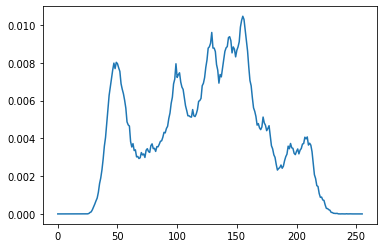

In [6]:
'''Do not run this cell, it takes time'''

img_file = 'lena_gray_512.tif'

intensities = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
unique, counts = np.unique(intensities, return_counts=True)

fintensities = intensities.astype(np.float)

height = np.shape(intensities)[0]
width = np.shape(intensities)[1]

u = unique.copy()
c = counts.copy()
for i in range(0,unique[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique[-1])
all_counts = np.append(c,z)
a = np.array(range(unique[-1]+1, 256))
var = np.append(u,a)

occurance_sum = sum(all_counts)
prbs = all_counts/occurance_sum
# plt.plot(var, all_counts)
plt.plot(var, prbs)
plt.savefig('distribution')

# print(intensities)
cv2.imshow('orig_image',intensities)
cv2.waitKey(1000)
filename = 'compressed_org_img.webp'
cv2.imwrite(filename, intensities)
cv2.waitKey(1000)

cells_num = 256



print('original image correlations:\n')
correlations(intensities)








######### ######### ######### ######### ######### ######### ######### #########
# NBIA
nb_all_yijs = []
nb_all_dijs = []
power = np.log2(cells_num)
for i in range(0,int(cells_num/2)):
    j = int(cells_num/2 + i)
#     print(i,j)

    '''Choose the strategy'''
# Strategy2
#     nb_yij = (var[i]+var[j])/2 # Strategy2
#     nb_all_yijs = np.append(nb_all_yijs, nb_yij) # Strategy2
    
#     nb_dij\
#         = var[i]**2*prbs[i] + nb_yij**2*prbs[i] - nb_yij*2*var[i]*prbs[i]\
#         + var[j]**2*prbs[j] + nb_yij**2*prbs[j] - nb_yij*2*var[j]*prbs[j] # Strategy2


# Strategy3
    nb_dij = 0.5*(\
      var[i]**2*prbs[i] + var[i]**2*prbs[i] - var[i]*2*var[i]*prbs[i]\
    + var[j]**2*prbs[j] + var[i]**2*prbs[j] - var[i]*2*var[j]*prbs[j]\
    + var[i]**2*prbs[i] + var[j]**2*prbs[i] - var[j]*2*var[i]*prbs[i]\
    + var[j]**2*prbs[j] + var[j]**2*prbs[j] - var[j]*2*var[j]*prbs[j]) # Strategy3

    nb_all_dijs = np.append(nb_all_dijs, nb_dij)
    
nb_distortion = np.sum(nb_all_dijs)
nb_db = 10 * np.log10(nb_distortion)

nb_prb0s = prbs[0: int(cells_num/2)]  
nb_prb0 = sum(nb_prb0s)
nb_entropy = -nb_prb0*np.log2(nb_prb0)-(1-nb_prb0)*np.log2(1-nb_prb0)

# print('\n',nb_distortion)
print('\nnb_DE(dB)',nb_db)
print('nb_H(S0)',nb_entropy)




# NB MSB plane
nb_msb_plane = np.zeros([height,width])
for i in range(0,height):
    for j in range(0,width):
        true_val = intensities[i][j]
        if true_val <= 127:
            nb_msb_plane[i][j] = 0 
        else:
            nb_msb_plane[i][j] = 1
            
nb_msb_plane255 = nb_msb_plane*255
nb_msb_uint8 = nb_msb_plane255.astype(np.uint8)
cv2.imshow('nb_msb_plane', nb_msb_uint8)
filename = 'nb_msb_plane_255.webp'
cv2.imwrite(filename, nb_msb_uint8)
cv2.waitKey(1000)

# NB 2nd MSB plane
nb_2nd_msb_plane = np.zeros([height,width])
for i in range(0,height):
    for j in range(0,width):
        true_val = intensities[i][j]
        if true_val < 64 or 128 <= true_val < 192:
            nb_2nd_msb_plane[i][j] = 0 
        else:
            nb_2nd_msb_plane[i][j] = 1
            
nb_2nd_msb_plane255 = nb_2nd_msb_plane*255
nb_2nd_msb_uint8 = nb_2nd_msb_plane255.astype(np.uint8)
cv2.imshow('nb_2nd_msb_plane', nb_2nd_msb_uint8)
filename = 'nb_2nd_msb_plane_255.webp'
cv2.imwrite(filename, nb_2nd_msb_uint8)
cv2.waitKey(1000)




# At Eve ######### ######### ######### ######### ######### ######### #########
# 1MSB Encryption

# Eve sets all MSBs to zero
eve_msb0 = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        if intensities[i][j] >= 128:
            eve_msb0[i][j] = intensities[i][j]-128

cv2.imshow('eve_msb0_nb', eve_msb0)
filename = 'eve_msb0_nb.webp'
cv2.imwrite(filename, eve_msb0)
cv2.waitKey(1000)

eve_dist0 = eve_distortion(eve_msb0)



# Eve sets all MSBs to 1
eve_msb1 = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        if intensities[i][j] < 128:
            eve_msb1[i][j] = intensities[i][j]+128

cv2.imshow('eve_msb1_nb', eve_msb1)
filename = 'eve_msb1_nb.webp'
cv2.imwrite(filename, eve_msb1)
cv2.waitKey(1000)

eve_dist1 = eve_distortion(eve_msb1)



eve_dist = 0.5 * (eve_dist0 + eve_dist1)
eve_dist_db = 10*np.log10(eve_dist)
print('\neve_distortion_1msb_nb', eve_dist_db)





print('\nCorrelation_NBIA_Eve sets all MSBs to 0:\n')
correlations(eve_msb0)

print('\nCorrelation_NBIA_Eve sets all MSBs to 1:\n')
correlations(eve_msb1)





# At Eve ######### ######### ######### ######### ######### ######### #########
# 2MSBs Encryption
eve_msb00 = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        if intensities[i][j] >= 128:
            msb1_to_zero = intensities[i][j]-128
            if msb1_to_zero >= 64: 
                msb2_to_zero = msb1_to_zero - 64
                # NB: Index and intensity value is the same
                eve_msb00[i][j] = msb2_to_zero
            else:
                eve_msb00[i][j] = msb1_to_zero

eve_dist00 = eve_distortion(eve_msb00)

cv2.imshow('eve_msb00_nb', eve_msb00)
filename = 'eve_msb00_nb.webp'
cv2.imwrite(filename, eve_msb00)
cv2.waitKey(1000)



eve_msb01 = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        if intensities[i][j] >= 128:
            msb1_to_zero = intensities[i][j]-128
            if msb1_to_zero < 64: 
                msb2_to_one = msb1_to_zero + 64
                # NB: Index and intensity value is the same
                eve_msb01[i][j] = msb2_to_one
            else:
                eve_msb01[i][j] = msb1_to_zero

eve_dist01 = eve_distortion(eve_msb01)

cv2.imshow('eve_msb01_nb', eve_msb01)
filename = 'eve_msb01_nb.webp'
cv2.imwrite(filename, eve_msb01)
cv2.waitKey(1000)



eve_msb10 = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        if intensities[i][j] < 128:
            msb1_to_one = intensities[i][j]+128
            if msb1_to_one >= (128 + 64): 
                msb2_to_zero = msb1_to_one - 64
                # NB: Index and intensity value is the same
                eve_msb10[i][j] = msb2_to_zero
            else:
                eve_msb10[i][j] = msb1_to_one

eve_dist10 = eve_distortion(eve_msb10)

cv2.imshow('eve_msb10_nb', eve_msb10)
filename = 'eve_msb10_nb.webp'
cv2.imwrite(filename, eve_msb10)
cv2.waitKey(1000)



eve_msb11 = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        if intensities[i][j] < 128:
            msb1_to_one = intensities[i][j]+128
            if msb1_to_one < (128 + 64): 
                msb2_to_one = msb1_to_one + 64
                # NB: Index and intensity value is the same
                eve_msb11[i][j] = msb2_to_one
            else:
                eve_msb11[i][j] = msb1_to_one

eve_dist11 = eve_distortion(eve_msb11)

cv2.imshow('eve_msb11_nb', eve_msb11)
filename = 'eve_msb11_nb.webp'
cv2.imwrite(filename, eve_msb11)
cv2.waitKey(1000)



eve_dist = 0.25 * (eve_dist00+eve_dist01+eve_dist10+eve_dist11)
eve_dist_db = 10*np.log10(eve_dist)
print('\neve_distortion_2msb_nb', eve_dist_db)




# Correlation for the image when Eve sets all MSBs to 00
print('\nCorrelation_NBIA_Eve sets all 2MSBs to 00:\n')
correlations(eve_msb00)

print('\nCorrelation_NBIA_Eve sets all 2MSBs to 01:\n')
correlations(eve_msb01)

print('\nCorrelation_NBIA_Eve sets all 2MSBs to 10:\n')
correlations(eve_msb10)

print('\nCorrelation_NBIA_Eve sets all 2MSBs to 11:\n')
correlations(eve_msb11)








# MIP #######################################################################
all_yijs = []
all_dijs = []
all_prb0s = []
for i in range(0,cells_num-1):
    for j in range(i+1,cells_num):
        
        '''Choose the strategy'''
# Strategy1: Eve knows the source statistics which is rare in image encrytion
#         possible_yij = (var[i]*prbs[i]+var[j]*prbs[j])\ 
#                        /(prbs[i]+prbs[j])

# '''Choose one strategy'''
# # Strategy2: Eve knows the reconstruction value of each cell
#         possible_yij = (var[i]+var[j])/2
#         #possibel_yij = random.choice([var[i],var[j]])
        
#         all_yijs = np.append(all_yijs, possible_yij)
        
#         possible_dij\
#         = var[i]**2*prbs[i] + possible_yij**2*prbs[i] - possible_yij*2*var[i]*prbs[i]\
#         + var[j]**2*prbs[j] + possible_yij**2*prbs[j] - possible_yij*2*var[j]*prbs[j]
        
# Strategy3
        yi = var[i]
        yj = var[j]
        possible_dij = 0.5*(
          var[i]**2*prbs[i] + yi**2*prbs[i] - yi*2*var[i]*prbs[i]\
        + var[j]**2*prbs[j] + yi**2*prbs[j] - yi*2*var[j]*prbs[j]\
        + var[i]**2*prbs[i] + yj**2*prbs[i] - yj*2*var[i]*prbs[i]\
        + var[j]**2*prbs[j] + yj**2*prbs[j] - yj*2*var[j]*prbs[j])
        
               
        all_dijs = np.append(all_dijs, possible_dij)
                
        possible_prb0 = max(prbs[j],prbs[i])
        all_prb0s = np.append(all_prb0s, possible_prb0)

######### ######### ######### ######### ######### ######### ######### #########
'''For distortion and entropy, we must implement the integer linear programming.'''
'''Linear programming does not results in binary values'''

all_length = int(cells_num * (cells_num-1) / 2)

A_eq = np.zeros([cells_num, all_length])
k = 0
for i in range(0, cells_num-1):
    for j in range(i+1,cells_num):
        A_eq[i,k]=1
        k+=1
k = 0
for j in range(1, cells_num):
    for i in range (j,cells_num):
        A_eq[i,k]=1
        k+=1

b_eq = np.ones([cells_num,])




'''Do not run this cell, it takes time'''
results_all_lambdas = []
for Lambda in [0]:

    results = mip_entropy_constrained(Lambda)

    eve_msb0 = results[5]
    eve_msb1 = results[6]
    eve_msb00 = results[7]
    eve_msb01 = results[8]
    eve_msb10 = results[9]
    eve_msb11 = results[10]

    eve_dist0 = eve_distortion(eve_msb0)
    eve_dist1 = eve_distortion(eve_msb1)

    eve_dist = 0.5 * (eve_dist0 + eve_dist1)
    eve_dist_db = 10*np.log10(eve_dist)
    print('\neve_distortion_1msb_lam'+str(Lambda), eve_dist_db)


    eve_dist00 = eve_distortion(eve_msb00)
    eve_dist01 = eve_distortion(eve_msb01)
    eve_dist10 = eve_distortion(eve_msb10)
    eve_dist11 = eve_distortion(eve_msb11)

    eve_dist_2msb = 0.25*(eve_dist00+eve_dist01+eve_dist10+eve_dist11)
    eve_dist_db_2msb = 10*np.log10(eve_dist_2msb)
    print('eve_distortion_2msb_lam'+str(Lambda), eve_dist_db_2msb)


    # Correlations
    print('\nCorrelation_lam'+str(Lambda)+'_Eve sets all MSBs to 0:\n')
    correlations(eve_msb0)

    print('\nCorrelation_lam'+str(Lambda)+'_Eve sets all MSBs to 1:\n')
    correlations(eve_msb1)

    # Correlation for the image when Eve sets all MSBs to 00
    print('\nCorrelation_lam'+str(Lambda)+'_Eve sets all 2MSBs to 00:\n')
    correlations(eve_msb00)

    print('\nCorrelation_lam'+str(Lambda)+'_Eve sets all 2MSBs to 01:\n')
    correlations(eve_msb01)

    print('\nCorrelation_lam'+str(Lambda)+'_Eve sets all 2MSBs to 10:\n')
    correlations(eve_msb10)

    print('\nCorrelation_lam'+str(Lambda)+'_Eve sets all 2MSBs to 11:\n')
    correlations(eve_msb11)
    
    
    results_all_lambdas = np.append(results_all_lambdas, results)

In [8]:
cv2.destroyAllWindows()

In [7]:
# print(results)

eve_msb0 = results[5]
eve_msb1 = results[6]
eve_msb00 = results[7]
eve_msb01 = results[8]
eve_msb10 = results[9]
eve_msb11 = results[10]

eve_dist0 = eve_distortion(eve_msb0)
eve_dist1 = eve_distortion(eve_msb1)

eve_dist = 0.5 * (eve_dist0 + eve_dist1)
eve_dist_db = 10*np.log10(eve_dist)
print('\neve_distortion_1msb_lam'+str(Lambda), eve_dist_db)


eve_dist00 = eve_distortion(eve_msb00)
eve_dist01 = eve_distortion(eve_msb01)
eve_dist10 = eve_distortion(eve_msb10)
eve_dist11 = eve_distortion(eve_msb11)

eve_dist_2msb = 0.25*(eve_dist00+eve_dist01+eve_dist10+eve_dist11)
eve_dist_db_2msb = 10*np.log10(eve_dist_2msb)
print('eve_distortion_2msb_lam'+str(Lambda), eve_dist_db_2msb)


# Correlations
print('\nCorrelation_lam'+str(Lambda)+'_Eve sets all MSBs to 0:\n')
correlations(eve_msb0)

print('\nCorrelation_lam'+str(Lambda)+'_Eve sets all MSBs to 1:\n')
correlations(eve_msb1)

# Correlation for the image when Eve sets all MSBs to 00
print('\nCorrelation_lam'+str(Lambda)+'_Eve sets all 2MSBs to 00:\n')
correlations(eve_msb00)

print('\nCorrelation_lam'+str(Lambda)+'_Eve sets all 2MSBs to 01:\n')
correlations(eve_msb01)

print('\nCorrelation_lam'+str(Lambda)+'_Eve sets all 2MSBs to 10:\n')
correlations(eve_msb10)

print('\nCorrelation_lam'+str(Lambda)+'_Eve sets all 2MSBs to 11:\n')
correlations(eve_msb11)


eve_distortion_1msb_lam0 39.4449389409017
eve_distortion_2msb_lam0 39.238925020592504

Correlation_lam0_Eve sets all MSBs to 0:

hcorr 0.5393139425857436
vcorr 0.5866426975933711
dcorr 0.5141721652836838

Correlation_lam0_Eve sets all MSBs to 1:

hcorr 0.7112303191826642
vcorr 0.7561649506413911
dcorr 0.6830443226759847

Correlation_lam0_Eve sets all 2MSBs to 00:

hcorr 0.5391553761861075
vcorr 0.5999674398105199
dcorr 0.5072843760456599

Correlation_lam0_Eve sets all 2MSBs to 01:

hcorr 0.3645888587983791
vcorr 0.41678713964170866
dcorr 0.34656097626854837

Correlation_lam0_Eve sets all 2MSBs to 10:

hcorr 0.6227185117126399
vcorr 0.6924376410834971
dcorr 0.5897814652403137

Correlation_lam0_Eve sets all 2MSBs to 11:

hcorr 0.48688166010221867
vcorr 0.5404015644291098
dcorr 0.46724832921893455


In [8]:
eve_dist0#lam0

2810.1747550964355

In [10]:
eve_dist1

14790.280025482178

In [11]:
eve_msb0 = intensities.copy() #nb
for i in range(0,height):
    for j in range(0,width):
        if intensities[i][j] >= 128:
            eve_msb0[i][j] = intensities[i][j]-128
            
eve_dist0 = eve_distortion(eve_msb0)

In [14]:
eve_dist0

8372.5625

In [15]:
eve_msb1 = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        if intensities[i][j] < 128:
            eve_msb1[i][j] = intensities[i][j]+128

eve_dist1 = eve_distortion(eve_msb1)

In [17]:
eve_dist1

8011.4375

In [25]:
#lam0 MSB000
mip_pairs_show = results[0]
dual_mip_xx = results[11]

ord_pairs = mip_pairs_show.copy()
for i in range(0, int(cells_num/2)):
    if mip_pairs_show[0][i] > mip_pairs_show[1][i]:
        ord_pairs[0][i] = mip_pairs_show[1][i]
        ord_pairs[1][i] = mip_pairs_show[0][i]

eve_msb000 = intensities.copy()
for i in range(0,height): # MSBs = 000
    for j in range(0,width):
        pair_index = np.where(
            ord_pairs == intensities[i][j])[1]
        
        if pair_index < 32:
            paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
            if prbs[intensities[i][j]] < prbs[paired_cell]:
                eve_msb000[i][j] = paired_cell[0]
        
        if 32 <= pair_index < 64:
            paired_pair_index = pair_index - 32
            alter1 = ord_pairs[0][paired_pair_index]
            alter2 = ord_pairs[1][paired_pair_index]
            if prbs[alter1] >= prbs[alter2]:
                eve_msb000[i][j] = alter1
            else:
                eve_msb000[i][j] = alter2
        
        if 64 <= pair_index < 96:
            paired_pair_index = pair_index - 64
            alter1 = ord_pairs[0][paired_pair_index]
            alter2 = ord_pairs[1][paired_pair_index]
            if prbs[alter1] >= prbs[alter2]:
                eve_msb000[i][j] = alter1
            else:
                eve_msb000[i][j] = alter2
        
        if 96 <= pair_index :
            paired_pair_index = pair_index -64-32
            alter1 = ord_pairs[0][paired_pair_index]
            alter2 = ord_pairs[1][paired_pair_index]
            if prbs[alter1] >= prbs[alter2]:
                eve_msb000[i][j] = alter1
            else:
                eve_msb000[i][j] = alter2
                
cv2.imshow('eve_msb000_lam'+str(Lambda), eve_msb000)
filename = 'eve_msb000_lam'+str(Lambda)+'.webp'
cv2.imwrite(filename, eve_msb000)
cv2.waitKey(1000)

eve_distortion(eve_msb000)

array([[156, 156, 156, ..., 149, 155, 135],
       [156, 156, 156, ..., 149, 155, 135],
       [156, 156, 156, ..., 149, 155, 135],
       ...,
       [145, 145, 149, ..., 144, 153, 154],
       [150, 150, 139, ..., 144, 151, 150],
       [150, 150, 139, ..., 144, 151, 150]], dtype=uint8)

2734.964252471924

# RANDOM MSB ASSIGNMENT

In [16]:
#MIP Index Assignment (Random and Not Entropy Consideration)
import random

#random msb assignment to each pair(then it will be fixed)
random.seed(0)

mip_pairs_show = results[0]
dual_mip_xx = results[11]

ord_pairs = mip_pairs_show.copy()
for i in range(0, int(cells_num/2)):
    if mip_pairs_show[0][i] > mip_pairs_show[1][i]:
        ord_pairs[0][i] = mip_pairs_show[1][i]
        ord_pairs[1][i] = mip_pairs_show[0][i]
        
all_msb0_pairs = []
for i in range(0, int(cells_num/2)):
    pair = [ord_pairs[0][i], ord_pairs[1][i]]
    msb0_pair = pair[random.randint(0,1)]
    all_msb0_pairs = np.append(all_msb0_pairs,msb0_pair)  

#random pair assignment to 128 pairs
random.seed(1)

rand_pair_indexes = []
num_pairs_set = list(range(128))
for i in range(128):
    rand_index = random.choice(num_pairs_set)
    rand_pair_indexes = np.append(rand_pair_indexes, rand_index)
    num_pairs_set.remove(rand_index)

pairs_with_index = np.array([ord_pairs[0], ord_pairs[1], rand_pair_indexes])


In [17]:
#MIP: Eve reconstruction, just 1 msb, all 0
dual_mip_xx = results[11]
mip_random_msb0 = intensities.copy()
# Encryption and then Eve recounstruction
for i in range(0,height):
    for j in range(0,width):
        if intensities[i][j] in all_msb0_pairs:
            mip_random_msb0[i][j] = intensities[i][j]
        else:
            paired_cell = np.where(
                dual_mip_xx[intensities[i][j]] == 1)
            mip_random_msb0[i][j] = paired_cell[0]

cv2.imshow('mip_random_1msb0', mip_random_msb0)
filename = 'mip_random_1msb0'+'.webp'
cv2.imwrite(filename, mip_random_msb0)
cv2.waitKey(1000)

mip_distortion_1msb0 = eve_distortion(mip_random_msb0)

In [18]:
mip_distortion_1msb0

7767.782764434814

In [19]:
cv2.destroyAllWindows()

In [20]:
#Eve reconstruction, more than one msb
all_possible_msbs_enc = np.array(list(range(7)))+2

mip_distortions = []
for enc_msb_plane_num in all_possible_msbs_enc:

    mip_random_msb = intensities.copy()
    step_size = int(128/(2**(enc_msb_plane_num-1)))
    boarders = list(range(0,128,step_size))

    for i in range(0,height):
        for j in range(0,width):
            pair_index_raw = np.where(
            pairs_with_index == intensities[i][j])
            position = pair_index_raw[1][0]
            pair_index = pairs_with_index[2][position]

            for k in boarders:
                if k <= pair_index < (k+step_size):
                    paired_pair_index = int(pair_index - k)
                    index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
                    alter1 = ord_pairs[0][index_position]
                    alter2 = ord_pairs[1][index_position]
                    if alter1 in all_msb0_pairs:
                        mip_random_msb[i][j] = alter1
                    else:
                        mip_random_msb[i][j] = alter2

    cv2.imshow('mip_random_'+str(enc_msb_plane_num)+'msbs0', mip_random_msb)
    filename = 'mip_random_'+str(enc_msb_plane_num)+'msbs0.webp'
    cv2.imwrite(filename, mip_random_msb)
    cv2.waitKey(1000)

    mip_distortion = eve_distortion(mip_random_msb)
    mip_distortions = np.append(mip_distortions, mip_distortion)   


In [13]:
cv2.destroyAllWindows()

In [11]:
#NBIA
all_possible_msbs_enc = np.array(list(range(8)))+1

nb_distortions = []
nb_high_contrast_distortions = []
for enc_msb_plane_num in all_possible_msbs_enc:
    
    nb_random_msb = intensities.copy()
    step_size = int(128/(2**(enc_msb_plane_num-1)))
    boarders = list(range(0,256,step_size))

    for i in range(0,height):
        for j in range(0,width):               
            for k in boarders:
                if k <= intensities[i][j] < k+step_size:
                    nb_random_msb[i][j] = intensities[i][j]-k

    cv2.imshow('nb_random_'+str(enc_msb_plane_num)+'msbs0', nb_random_msb)
    filename = 'nb_random_'+str(enc_msb_plane_num)+'msbs0.webp'
    cv2.imwrite(filename, nb_random_msb)
    cv2.waitKey(1000)

    nb_distortion = eve_distortion(nb_random_msb)
    nb_distortions = np.append(nb_distortions, nb_distortion)


    nb_high_contrast1 = (nb_random_msb+1.0)*2**(enc_msb_plane_num)-1
    nb_high_contrast = nb_high_contrast1.astype(np.uint8)

    cv2.imshow('nb_highcontrast_'+str(enc_msb_plane_num)+'msbs0', nb_high_contrast)
    filename = 'nb_highcontrast_'+str(enc_msb_plane_num)+'msbs0.webp'
    cv2.imwrite(filename, nb_high_contrast)
    cv2.waitKey(1000)

    nb_high_contrast_distortion = eve_distortion(nb_high_contrast)
    nb_high_contrast_distortions = np.append(nb_high_contrast_distortions, 
                                             nb_high_contrast_distortion)


In [21]:
cv2.destroyAllWindows()

In [22]:
np.insert(mip_distortions,0, mip_distortion_1msb0)

array([ 7767.78276443,  7684.58773041,  7647.64428711,  8662.61777878,
        8678.50603867,  9239.35890961,  6979.60623932, 12100.53685379])

In [24]:
nb_distortions

array([ 8372.5625    , 11626.9375    , 14132.06640625, 15900.53808594,
       16828.50683594, 17309.51080322, 17554.04605103, 17677.91169357])

In [23]:
nb_high_contrast_distortions

array([ 8557.31137466,  9604.23596573,  7552.54446793,  8069.53781509,
        8019.7623024 ,  8670.41830826, 10897.06430435, 19438.68832779])